In [1]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

In [12]:
data_save=joblib.load("data_waveform/waveform_fiber_BCF92_laser_1pe.joblib")
time_series = data_save["metadata"]["time_series"]*1e9

In [24]:
c = Cut()

In [23]:
class Cut:
    # def __init__(self):
        # self.utils=Utils()

    class _UnbiasedEstimators(object):
        """
        //From QETpy: https://github.com/ucbpylegroup/QETpy
        Helper class for calculating the unbiased estimators of a 1D normal
        distribution that has been truncated at specified bounds.
        Attributes
        ----------
        mu0 : float
            The biased estimator of the mean of the inputted and truncated data.
        std0 : float
            The biased estimator of the standard deviation of the inputted and
            truncated data.
        mu : float
            The unbiased estimator of the mean of the inputted and truncated data.
        std : float
            The unbiased estimator of the standard deviation of the inputted and
            truncated data.
        """

        def __init__(self, x, lwrbnd, uprbnd):
            """
            Initialization of the `_UnbiasedEstimators` helper class
            Parameters
            ----------
            x : ndarray
                A 1D array of data that has been truncated, for which the unbiased
                estimators will be calculated.
            lwrbnd : float
                The lower bound of the truncation of the distribution.
            uprbnd : float
                The upper bound of the truncation of the distribution.
            """

            inds = (np.asarray(x) >= lwrbnd) & (np.asarray(x) <=uprbnd)

            self._lwrbnd = lwrbnd
            self._uprbnd = uprbnd

            self._x = x[inds] # make sure data is only between the specified bounds
            self._sumx = np.sum(self._x)
            self._sumx2 = np.sum(self._x**2)
            self._lenx = len(self._x)

            self.mu0 = np.mean(self._x)
            self.std0 = np.std(self._x)

            self._calc_unbiased_estimators()

        def _equations(self, p):
            """
            Helper method for calculating the system of equations that will be
            numerically solved for find the unbiased estimators.
            Parameters
            ----------
            p : tuple
                A tuple of length 2 containing the current estimated values of the
                unbiased estimators: (mu, std).
            Returns
            -------
            (mu_eqn, std_eqn) : tuple
                A tuple containing the two equations that will be solved to give the
                unbiased estimators of the mean and standard deviation of the data.
            """

            mu, std = p

            pdf_lwr = stats.norm.pdf(self._lwrbnd, loc=mu, scale=std)
            pdf_upr = stats.norm.pdf(self._uprbnd, loc=mu, scale=std)

            cdf_lwr = stats.norm.cdf(self._lwrbnd, loc=mu, scale=std)
            cdf_upr = stats.norm.cdf(self._uprbnd, loc=mu, scale=std)

            mu_eqn = self._sumx - self._lenx * mu
            # term due to truncation
            mu_eqn += self._lenx / (cdf_upr - cdf_lwr) * (pdf_upr - pdf_lwr)

            std_eqn = self._sumx2 - 2 * mu * self._sumx + self._lenx * mu**2 - self._lenx * std**2
            # term due to truncation
            std_eqn += self._lenx * std**2 / (cdf_upr - cdf_lwr) * ((self._uprbnd - mu) * pdf_upr - (self._lwrbnd - mu) * pdf_lwr)

            return (mu_eqn, std_eqn)

        def _calc_unbiased_estimators(self):
            """
            Method for calculating the unbiased estimators of the truncated distribution.
            """

            self.mu, self.std = scipy.optimize.fsolve(self._equations, (self.mu0, self.std0))

    def removeoutliers(self, data, skew_target=0.05, skew_itermax=20, std_target=3, std_itermax=20, std_precision=1000, return_unbiased_estimates=False, axis=0, verbose=False):
        """
        Removing outliers by
          1) skewness (minimizing to skewtarget)
          2) standard deviation

        Parameters
            x : array
                Array of real-valued variables from which to remove outliers.
            skew_target:
        Returns
            inds : ndarray
                Boolean indices
        """
        # 0) Adapt to data type
        if type(data) is list:
            data=np.array(data)
        if data.ndim==1:
            x=data


        # 1) Skewness cut
        if skew_target is not None:
            i=1
            inds=(x != np.inf)
            sk=scipy.stats.skew(x[inds])
            while(abs(sk) > skew_target):
                dmed=x-np.median(x[inds])
                dist=np.min([abs(min(dmed)),abs(max(dmed))])
                inds=inds & (abs(dmed) < dist)
                sk=scipy.stats.skew(x[inds])
                if(i > skew_itermax):
                    if verbose:
                        print(f"Skew Reaching maximum {skew_itermax} iterations. Stop at skew of {sk}")
                    break
                i+=1
        else:
            inds=np.ones(len(x),dtype=bool)

        # 2) Standard deviation cut
        if std_target is not None:
            # Trun the relative precision into absolute, in the unit of standard deviation
            std_precision_abs = np.std(x)/std_precision
            mean_last = np.mean(x[inds]); std_last = np.std(x[inds]);
            i=0
            nstable = 0

            while nstable <= 3:
                mask = inds& (abs(scipy.stats.zscore(x)) < std_target)
                if sum(mask) <=1 and verbose:
                    warnings.warn(
                        "The number of events passing iterative cut via iterstat is <= 1. "
                        "Iteration not converging properly. Returning simple mean and std. "
                        "No data will be cut."
                    )
                    mask = inds&np.ones(len(x),dtype=bool)
                    mean_this = np.mean(x[mask])
                    std_this = np.std(x[mask])
                    break

                mean_this = np.mean(x[mask])
                std_this = np.std(x[mask])

                if (abs(mean_this - mean_last) > std_precision_abs) or (abs(std_this - std_last) > std_precision_abs):
                    nstable = 0
                else:
                    nstable = nstable + 1

                mean_last = mean_this
                std_last = std_this

                i+=1
                if(i > std_itermax):
                    if verbose:
                        print(f"STD Reaching maximum {std_itermax} iterations. Stop at standard deviation of {std_last}")
                    break

        # 3. Calculate mean and stddev
        if return_unbiased_estimates:
            unb = self._UnbiasedEstimators(x[mask], mean_this - std_target * std_this, mean_this + std_target * std_this)
            mean_this=unb.mu; std_this=unb.std

        return mask, mean_this, std_this


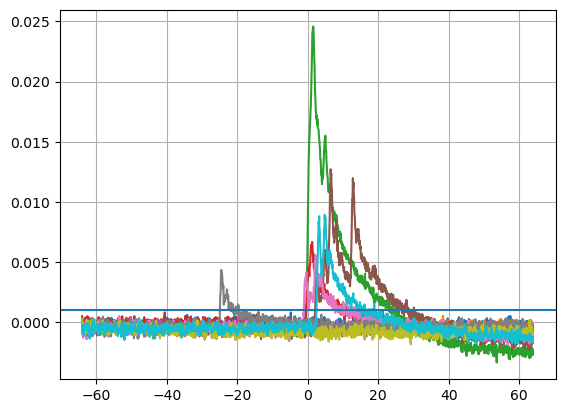

In [14]:
# Have a look at one pulse, and choose a trigger threshold
trigger_threshold_edge = 0.001

for i in range(10):
    plot(time_series, data_save[1][i])
axhline(trigger_threshold_edge)

# xlim(-2,8)
grid()

In [15]:
trace_selected = []
for i in tqdm(range(len(data_save[1]))):
# for i in tqdm(range(1000)):
    for ch in [1]:
        x=time_series
        y=data_save[ch][i]
        dt = (time_series[1]-time_series[0])
        if max(y)>trigger_threshold_edge:
            trace_selected.append(y)
        

100%|██████████| 3600/3600 [00:00<00:00, 15101.02it/s]


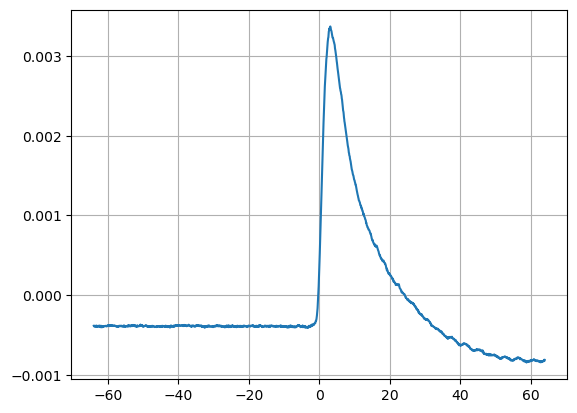

In [17]:
plot(time_series, np.mean(trace_selected, axis=0))
grid()

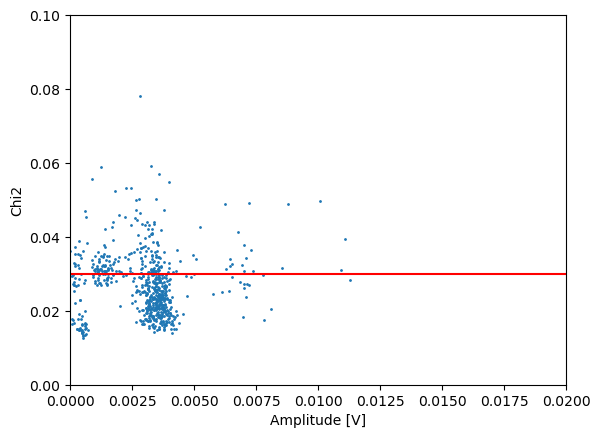

In [5]:
# Chi2 cut
scatter(process_result[f"amplitude_fit_1"],process_result[f"fit_chi2_1"] , s=1);
xlim(0,0.02)
ylim(0,0.1)
xlabel("Amplitude [V]")
ylabel("Chi2")

chi2_cut_threshold = 0.03
axhline(chi2_cut_threshold,color="r")

10%-90% rise time 0.33681911363610023 ns


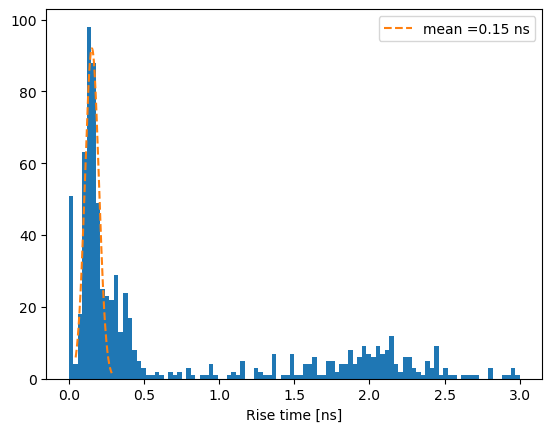

In [8]:
#  Rise time
h=hist(process_result[f"trise_fit_{ch}"],bins=100,range=(0,3));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="mean ={popt[1]:.2f} ns", color="C1", linestyle="--", fit_range=(0.02,0.3));

xlabel("Rise time [ns]")
legend()

print("10%-90% rise time", 2.2*popt[1], "ns")

Amplitude of the first eh: 0.0034980090553964048


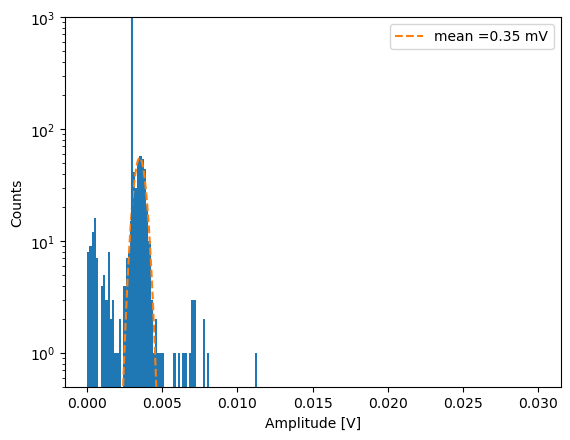

In [10]:
h=hist(process_result[f"amplitude_fit_1"][process_result[f"fit_chi2_1"]<chi2_cut_threshold], bins=np.linspace(0,0.03,200));

popt, pcov, info, f = hp.fit_hist("gauss", h, label="mean ={popt[1]*100:.2f} mV", color="C1", linestyle="--", fit_range=(0.0005,0.01));


legend()
xlabel("Amplitude [V]")
ylabel("Counts")
yscale("log")
ylim(0.5,1e3)
legend()

amp2eh = popt[1] # 2.5 mV/eh
print("Amplitude of the first eh:",popt[1])
axvline(0.003)

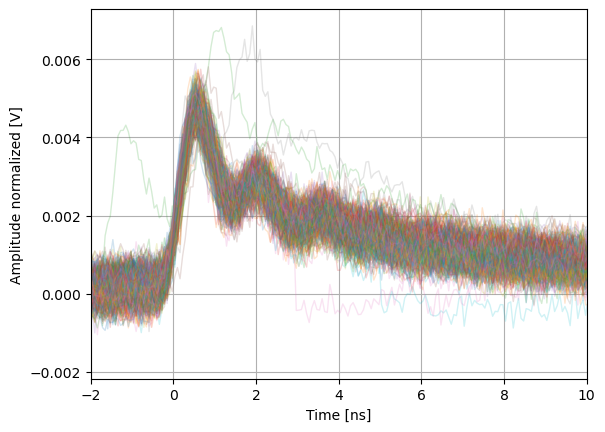

In [12]:
# for i in range(len(data_save[1])):
trace_original = []
trace_aligned = []
trace_amps = []
time_series = data_save["metadata"]["time_series"]*1e9
for i in range(len(data_save[1])):
# for i in range(100):
    trace = data_save[1][i]
    trace-= np.mean(trace[:1024-200])
    # if (max(trace)>0.025) or  (max(trace)<0.02) or (min(trace)<-0.005):
    #     continue     
    # leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
    # trigger_offset = leading_edges[0][1]-2048
    # trigger_offset = np.argmax( y>trigger_threshold_edge)-2048
    
    if process_result["fit_chi2_1"][i] > chi2_cut_threshold:
        continue
    # if abs(process_result["amplitude_fit_1"][i]-popt[1])>0.003:
    if process_result["amplitude_fit_1"][i]<0.003 or process_result["amplitude_fit_1"][i]>0.005:
        continue
    
    amp = process_result["amplitude_fit_1"][i]
    trace_amps.append(amp)
    # trace/=amp

    trigger_offset = int(process_result["trigger_time_fit_1"][i]/dt)
    
    trace_original.append(trace)
    trace = np.roll(trace, -trigger_offset)
    trace_aligned.append(trace)
    
    if i <2000:
        plot(time_series, trace,alpha=0.2, linewidth=1)

xlim(-2,10)
xlabel("Time [ns]")
ylabel("Amplitude normalized [V]")
grid()

[ 4.25499207e-01  4.26926206e-01  7.14901229e+00  2.19831476e+00
  3.83965107e-03 -9.85811598e-02  4.09872896e-03]


/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)


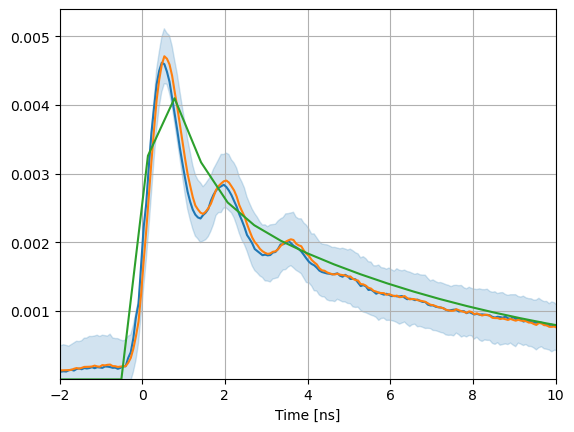

In [13]:
trace_original_avg = np.mean(trace_original, axis=0)#*np.mean(trace_amps)
trace_aligned_avg = np.mean(trace_aligned, axis=0)#*np.mean(trace_amps)
trace_aligned_std = np.std(trace_aligned, axis=0)#*np.mean(trace_amps)


scintillator_pulse_15eh_save = [time_series, trace_aligned_avg, trace_aligned_std]
np.save("scintillator_pulse_15eh", scintillator_pulse_15eh_save)


plot(time_series, trace_original_avg)
plot(time_series, trace_aligned_avg)
fill_between(time_series, trace_aligned_avg-trace_aligned_std, trace_aligned_avg+trace_aligned_std, color="C0", alpha=0.2)


x=time_series
y=trace_aligned_avg
popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, p0=[0.5,3,30,np.max(y),np.max(y),x[np.argmax(y)],np.max(y)], maxfev=1000, makeplot=True)

# yscale("log")
xlim(-2,10)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")
print(popt)

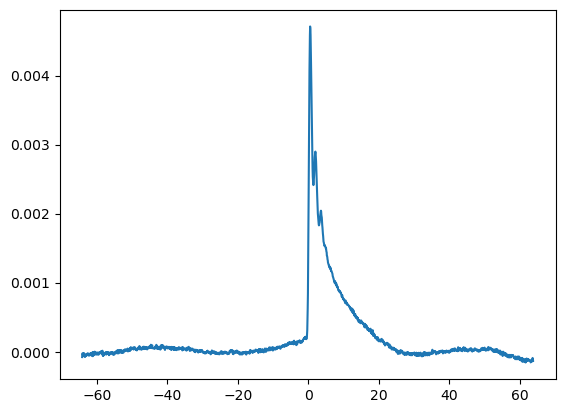

In [15]:
plot(time_series,trace_aligned_avg)

In [14]:
pulse_save = {"time_series_ns":time_series,
              "averaged_pulse_1pe_volt":trace_aligned_avg}
joblib.dump(pulse_save,"data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib")

['data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib']